# Scraping steam to get game description and tags

I this section we will build a web scraper that downloads the game description and tags for each game on the steam web page. We will be using the python module Beautiful Soup for this. The final result will be a .csv file with all the game descriptions as well as matrix containing tags for each game.

First we import the relevant modules

In [1]:
import csv                    # For saving the files
from bs4 import BeautifulSoup # For the web scraper
import requests               # To handle web requests
import numpy as np            # The tags will be saved as a matrix
import time                   # For setting a sleep timer during the scaping 
import xml.etree.ElementTree  # 

As a first example we will see how Beautiful Soup handles a spicific page.

In [2]:
page = requests.get("http://store.steampowered.com/app/396560")
soup = BeautifulSoup(page.content, 'html.parser')

## Getting screenshots

In [3]:
screen_shot = soup.select('body div[class="highlight_strip_screenshot"]') #[name="highlight_strip_screenshot"]
screen_shot

[]

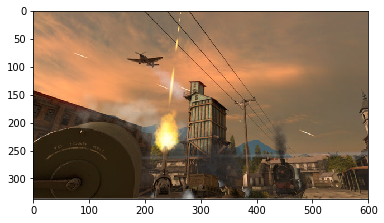

In [4]:
import urllib
import matplotlib.pyplot as plt

# create a file-like object from the url
f = urllib.request.urlopen("http://cdn.edgecast.steamstatic.com/steam/apps/396560/ss_958d467a58b1961816728c9a9d8f306e6b762db9.600x338.jpg?t=1501589631")

# read the image file in a numpy array
a = plt.imread(f, format='jpg')
plt.imshow(a)
plt.show()

## Getting the game description

Using the inspect tool in e.g. Google Chrome we can see that the game description has been given a name space.  Beautiful Soup allow us to give a CSS selector.

In [5]:
description = soup.select('[name="Description"]')
print(description[0])

<meta content="“Front Defense” immerses you into the WW2 battlefield, When you shoot, throw grenades, Vive will track your location accurately. Destroy enemy with rocket tube and guns. Fully equipped troops with advanced weapons are waiting for you in the game. Make the best of your weapons to gain the victory." name="Description"/>


The function returns the entire element, so we have to cut off the beginning and end of the string.

In [6]:
type(description[0])

bs4.element.Tag

In [7]:
text = str(description[0])
text[15:-22]

'“Front Defense” immerses you into the WW2 battlefield, When you shoot, throw grenades, Vive will track your location accurately. Destroy enemy with rocket tube and guns. Fully equipped troops with advanced weapons are waiting for you in the game. Make the best of your weapons to gain the victory.'

So now we have the game description as a string which we can easily save to a csv file.

## Getting the game tags

Since we are building a classifer to predict the tags, we need to save those as well. Once again we inspect the site to look for the CSS selector. In this case each tag has been given the class "app_tag".

In [8]:
genres = soup.select('body div [class="app_tag"]')
for genre in genres:
    print(genre.get_text().strip())

Action
Violent
VR
World War II


So we are able to get what we want: The game descriptions and tags. Now we need a convienient way to loop through all the games. We saw earlier that the urls of the steam web page is structured around the game IDs like so: http://store.steampowered.com/app/game_ID. This makes it easy for us to loop through all the games if we have a complete list of the game IDs.

## Getting a list of all relevant game ids

If we did not have a complete list of all the game IDs on steam we would need to simply loop through positive integers starting from 0 -- this is doable but it would be slow. We also would not know when to stop the looping. Luckily I have such a list.

In [ ]:
e = xml.etree.ElementTree.parse('../data/api_steampowered.xml')
for atype in e.findall('applist'):
    print(atype)

In [ ]:
root = e.getroot()

In [ ]:
game_ids = []
for idx in range(len(root[0])):
    game_id = root[0][idx][0].text
    name = root[0][idx][1].text
    game_ids.append(game_id)

In [ ]:
print('The number of games on steam is: ', len(game_ids))

That is a lot of games, which is good because some machine learning algorithms require a decent amount of data.

# Looping over all games

Now we will put everything together in a single loop. We will create three lists: The first contains the game descriptions. The second list contains a list of tags for each game. The third list contains a single copy of each tag we encounter during the scraping. This last is nescessary because we need to know how many tags there are when we create the matrix representation of the tags for each game.

In [ ]:
game_descriptions = []
game_tags = []
complete_tag_list = []
for game_id in game_ids:
    #sleep_time = np.random.randint(0,2)
    #time.sleep(sleep_time)
    
    # Requesting the page
    page = requests.get("http://store.steampowered.com/app/"+str(game_id), allow_redirects=False )
    soup = BeautifulSoup(page.text, 'html.parser')
    
    # Getting the game description
    description = soup.select('meta[name="Description"]')
    if len(description)>0:
        text = str(description[0])
        description = text[15:-22]
        game_descriptions.append(description)
    
        # Getting the genres
        tags_list = []
        tags = soup.select('body div [class="app_tag"]')
        for item in tags:
            tag = item.get_text().strip()
            tags_list.append(tag)
            if tag not in complete_tag_list:
                complete_tag_list.append(tag)
        game_tags.append(tags_list)

# Saving the data

We save the three lists described above to csv files so we can load them easily later.

In [ ]:
with open('data/steam_game_descriptions.txt', 'w') as fp:
    a = csv.writer(fp) 
    a.writerow(game_descriptions)
    
with open('data/steam_game_tags.txt', 'w') as fp:
    a = csv.writer(fp) 
    for genres in game_genres:
        a.writerow(genres)
    
with open('data/steam_complete_tag_list.txt', 'w') as fp:
    a = csv.writer(fp) 
    a.writerow(complete_genre_list)

In [ ]:
len(game_descriptions)

# Doing one-hot encoding of the genres

This last step it not strictly nescessary, but it will make the machine learning part easier, so we might as well do it now. Rather than having a list of all the tags for each game we want a matrix where each row represents a game and each column a unique tag. Each element of the matrix will be be 0 or 1 depending on wether or not the game has the tag or not. This is why we needed the complete list of the tags, so we know how many columns the matrix should have.

In [ ]:
len(complete_tag_list)

First we create a dictionary that maps game tags to column numbers in the tag matrix

In [ ]:
tag_to_idx_dict = {}
for idx, tag in enumerate(complete_tags_list):
    tag_to_idx_dict[tag] = idx

We create a matrix filled with zeros, so all we need to do is set the elements to 1 for each tag a game has. We do this by looping over each element in the game tags list. The element is itself a list, so we loop through that as well.

In [ ]:
tag_matrix = np.zeros( (len(game_descriptions), len(complete_tags_list)) )
for idx, tag_list in enumerate(game_tags):
    for tag in tag_list:
        tag_idx = tag_to_idx_dict[tag]
        tag_matrix[idx, tag_idx] = 1

Finally we save the tag matrix:

In [ ]:
np.save('data/steam_tag_metrix', tag_matrix)

Now we have everything we need to train and test our tag classifier.